In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
from PIL import Image
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
from IoU import IoU
from replay_buffer import ReplayBuffer
import collections
from PIL import ImageDraw
import random
import re
#import train
#----------------read data-----------------------
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
image_sets =  ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',\
      'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', \
      'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets, input_transform = None, \
                 target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        #label = torch.LongTensor([[y]])
        img = Image.open(fn).convert('RGB')
        #box = torch.LongTensor([[xmin, ymin, xmax, ymax]])
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, fn

    def __len__(self):
        return len(self.imgs)

img_data = Data(imgs, image_sets, input_transform = input_transform, \
                target_transform = None, test=None)
test_data = Data(imgs, image_sets, input_transform = input_transform, \
                 target_transform = None, test = True)
#print(len(img_data.imgs))
img_batch = data.DataLoader(img_data, batch_size = 1 ,shuffle = True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size = 1, shuffle = True, num_workers = 2)
print len(img_batch)

5717


In [2]:
def Transition(box):
    x_img = img[:, :, box[1]:box[3]+1, box[0]:box[2]+1]
    return x_img

def Cat_State(box_img, img):
    roi_pooling = nn.AdaptiveAvgPool2d((2, 2))
    state1 = roi_pooling(box_img).view(-1)
    #state2 = roi_pooling(Extractor.forward(Variable(img, volatile = True))).view(-1)
    state2 = roi_pooling(Extractor.forward(Variable(img))).view(-1)
    state = torch.cat((state1, state2), 0).unsqueeze(0)
    return state

In [30]:
box_img = Transition(ground_truth[0])

In [37]:
#print Variable(cls[j]).cuda()
print Variable(torch.LongTensor([cls[0]])).cuda()

Variable containing:
 14
[torch.cuda.LongTensor of size 1 (GPU 0)]



In [4]:
resnet = models.resnet101(pretrained=True)
resnet.maxpool = nn.AdaptiveAvgPool2d((75, 75))
net = nn.Sequential(*list(resnet.children())[:-1])
#roi = nn.AdaptiveMaxPool2d((75,75))
resnet.fc = nn.Linear(2048, 20)
img, pack, fn = next(iter(img_batch))
print resnet(Variable(img))

Variable containing:

Columns 0 to 9 
-0.2404  0.1996  0.7388  0.5363  0.1905  0.4173 -0.1981 -0.1044 -0.1245 -0.1252

Columns 10 to 19 
-0.2819  0.4622  0.2222  0.2034  0.1057 -0.5470 -0.3974  0.2466 -0.1808  0.0115
[torch.FloatTensor of size 1x20]



In [43]:
resnet = models.resnet18(pretrained=True)
#resnet = torch.load('resnet184classification.pth')
#resnet.maxpool = nn.AdaptiveAvgPool2d((75, 75))
resnet.avgpool = nn.AdaptiveMaxPool2d((2, 2))
resnet.fc = nn.Linear(2048, 20)
#net = nn.Sequential(*list(resnet.children())[:-1])
print resnet.forward(Variable(box_img))
"""net = nn.Sequential(*list(resnet.children())[:-2])
roi = nn.AdaptiveMaxPool2d((2, 2))
fc = nn.Linear(2048, 20)
img, pack, fn= next(iter(img_batch))
print fc(roi(net(Variable(img))).view(-1)).unsqueeze(0)"""

RuntimeError: Variable data has to be a tensor, but got Variable

In [5]:
learning_rate =0.001
epoch = 50
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.Adam([{'params':model.parameters()},{'params':resnet.parameters()}],\
#lr=learning_rate)
optimizer = optim.Adam(resnet.parameters(), lr = learning_rate)
resnet.cuda()
loss=[]
lossmin = 0.
for i in range(epoch):
    for img, pack, fn in img_batch:
        num = int(pack.size(1) / 5)
        ground_truth = torch.LongTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
            box_img = Variable(Transition(ground_truth[j])).cuda()
            label = Variable(torch.LongTensor([cls[j]])).cuda()
            optimizer.zero_grad()
            output = resnet(box_img)
            #_, pred = torch.max(output.data,1)
            loss_ = loss_func(output,label[:, 0])
            loss_.backward()
            optimizer.step()
    loss.append(loss_.data[0])
    print('epoch: {}, loss: {}'.format(i + 1, loss_.data[0]))
    if i is 0:
        lossmin = loss_.data[0]
    if loss_.data[0] < lossmin:
        lossmin = loss_.data[0]
        torch.save(resnet, 'roi_net'+'.pth')

epoch: 1, loss: 1.49338459969
epoch: 2, loss: 2.26698827744
epoch: 3, loss: 3.10697364807
epoch: 4, loss: 1.76457822323
epoch: 5, loss: 3.21612977982
epoch: 6, loss: 2.02116823196
epoch: 7, loss: 5.25745677948
epoch: 8, loss: 2.05392551422
epoch: 9, loss: 3.09744215012
epoch: 10, loss: 0.573021650314
epoch: 11, loss: 3.47786426544
epoch: 12, loss: 1.97980117798
epoch: 13, loss: 2.33223772049
epoch: 14, loss: 2.87138843536
epoch: 15, loss: 0.776550292969
epoch: 16, loss: 3.64056372643
epoch: 17, loss: 0.286214590073
epoch: 18, loss: 0.27937746048
epoch: 19, loss: 4.05535316467
epoch: 20, loss: 1.26800107956
epoch: 21, loss: 0.289633274078
epoch: 22, loss: 0.9065990448
epoch: 23, loss: 2.1411075592
epoch: 24, loss: 0.147664546967
epoch: 25, loss: 5.01729488373
epoch: 26, loss: 3.03770637512
epoch: 27, loss: 2.59687423706
epoch: 28, loss: 2.19838619232
epoch: 29, loss: 2.77343177795
epoch: 30, loss: 0.703294754028
epoch: 31, loss: 3.72428321838
epoch: 32, loss: 1.12459373474
epoch: 33, lo

Process Process-71:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
Process Process-72:
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  Fil

KeyboardInterrupt: 

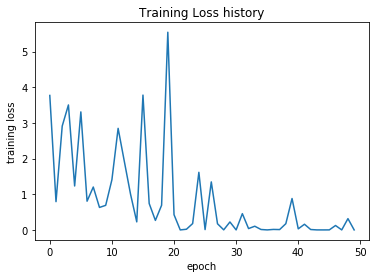

In [41]:
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [42]:
model = torch.load('roi_net.pth').cuda()
import tqdm
def evaluate(model, data_loader):
    score = []
    model.eval()
    total = 0
    correct = 0
    for i, (img, pack, fn) in tqdm.tqdm(enumerate(data_loader),
                                               total=Dataset_length,
                                               ncols=80, leave=False):
        num = int(pack.size(1) / 5)
        ground_truth = torch.LongTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
            box_img = Variable(Transition(ground_truth[j], img)).cuda()
            label = Variable(torch.LongTensor([cls[j]])).cuda()
            
            output = model(box_img)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (pred == label.data).sum()   
        if i % 100 == 0:
            score.append(float(correct)/total)
        #score = torch.nn.functional.upsample_bilinear(score, (1280, 1918))
    return score
Dataset_length = len(test_data)
#net = torch.load('roi_net40.pth')
score = evaluate(model, test_batch)

plt.plot(score[1:],'-o')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.title('Test Accuracy')
plt.show()

TypeError: Transition() takes exactly 1 argument (2 given)

In [6]:
#text accuracy
resnet.eval()
correct = 0
total = 0

for i, (img,label, pack, fn) in enumerate(test_batch):
    img = Variable(img).cuda()
    label = Variable(label).cuda()
    
    output = resnet(img)
    _, pred = torch.max(output.data,1)
    total += label.size(0)
    correct += (pred == label.data).sum()   
    if i % 100 == 0:
        print("Accuracy: {}".format(float(correct)/total ))
#print("Accuracy: {}".format(correct/total))

Accuracy: 0.0
Accuracy: 0.217821782178
Accuracy: 0.194029850746
Accuracy: 0.202657807309
Accuracy: 0.211970074813
Accuracy: 0.22754491018
Accuracy: 0.257903494176
Accuracy: 0.266761768902
Accuracy: 0.265917602996
Accuracy: 0.263041065483
Accuracy: 0.264735264735
Accuracy: 0.262488646685
Accuracy: 0.259783513739
Accuracy: 0.261337432744
Accuracy: 0.260528194147
Accuracy: 0.252498334444
Accuracy: 0.251093066833
Accuracy: 0.253380364491
Accuracy: 0.254303164908
Accuracy: 0.253550762756
Accuracy: 0.255872063968
Accuracy: 0.256544502618
Accuracy: 0.258064516129
Accuracy: 0.261625380269
Accuracy: 0.262807163682
Accuracy: 0.265893642543
Accuracy: 0.264513648597
Accuracy: 0.264716771566
Accuracy: 0.263477329525
Accuracy: 0.261978628059
Accuracy: 0.26124625125
Accuracy: 0.263463398904
Accuracy: 0.263667603874
Accuracy: 0.263253559527
Accuracy: 0.264628050573
Accuracy: 0.267066552414
Accuracy: 0.265204109969
Accuracy: 0.265063496352
Accuracy: 0.263877926861
Accuracy: 0.264034862856
Accuracy: 0.2